### 1. Importing libraries and data exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import Image

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

sns.set_theme(palette="Set2", style="darkgrid")

#### 1.1. Data read-in

In [2]:
df = pd.read_excel("data.xlsx", sheet_name="Online Retail")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#### 1.2. Making sure features are correct data type

In [3]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

#### 1.3. Unique countries

- Since there is a large number of countries from which customers placed orders, using this information in clustering might be challenging.

In [4]:
df.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [5]:
customer_count = df.CustomerID.nunique()
customer_count

4372

There are only 4372 unique customers

In [6]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,541909.0,9.55225,-80995.0,1.0,3.0,10.0,80995.0,218.081158
InvoiceDate,541909,2011-07-04 13:34:57.156386048,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 17:17:00,2011-10-19 11:27:00,2011-12-09 12:50:00,NaN
UnitPrice,541909.0,4.611114,-11062.06,1.25,2.08,4.13,38970.0,96.759853
CustomerID,406829.0,15287.69057,12346.0,13953.0,15152.0,16791.0,18287.0,1713.600303


#### 1.4. Checking missing values

In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Unfortunately, one-quarter of the orders lack a unique *CustomerID*, resulting in a loss of 25% of the data. Regrettably, there isn't much that can be done to address this issue.

In [8]:
df = df.dropna(subset="CustomerID")

### 2. Feature engineering

- To simplify orders, the product of *Unit Price* and *Quantity* is computed and consolidated into a new column named *Total spendings*.

In [9]:
df["Total spendings"] = df["Quantity"] * df["UnitPrice"]

In [10]:
df.drop(columns=["Quantity", "UnitPrice"], inplace=True)

#### 2.1. Grouping *Total spendings* by each unique *Customer*

In [11]:
spendings_by_customer = df.groupby("CustomerID")["Total spendings"].sum().reset_index()
spendings_by_customer.sort_values("Total spendings", ascending=False)

,CustomerID,Total spendings
1703,14646.0,279489.02
4233,18102.0,256438.49
3758,17450.0,187482.17
1895,14911.0,132572.62
55,12415.0,123725.45
...,...,...
125,12503.0,-1126.00
3870,17603.0,-1165.30
1384,14213.0,-1192.20
2236,15369.0,-1592.49


#### 2.1. Counting *Number of orders* each *Customer* made

In [12]:
NO_purchases_by_customer = df.groupby("CustomerID")["InvoiceNo"].count().reset_index()
NO_purchases_by_customer.rename(columns={"InvoiceNo": "Total purchases"}, inplace=True)
NO_purchases_by_customer.sort_values("Total purchases", ascending=False)

,CustomerID,Total purchases
4042,17841.0,7983
1895,14911.0,5903
1300,14096.0,5128
330,12748.0,4642
1674,14606.0,2782
...,...,...
1318,14119.0,1
1046,13747.0,1
2400,15590.0,1
2379,15562.0,1


#### 2.2. Recency of orders
- Calculating how many days passed compared to most recent (max) purchase from whole data for each customer

In [13]:
max_purchase_date = df["InvoiceDate"].max()

last_purchase_df = df.groupby("CustomerID")["InvoiceDate"].max().reset_index()

last_purchase_df["Days since last purchase"] = (
    max_purchase_date - last_purchase_df["InvoiceDate"]
).dt.days

customer_last_purchase_df = last_purchase_df[["CustomerID", "Days since last purchase"]]
customer_last_purchase_df.sort_values("Days since last purchase", ascending=True)

,CustomerID,Days since last purchase
3784,17491.0,0
3392,16933.0,0
3113,16558.0,0
524,13026.0,0
3691,17364.0,0
...,...,...
4212,18074.0,373
359,12791.0,373
4096,17908.0,373
3129,16583.0,373


#### 2.3. Combining features

- Merging data by *CustomerID*

In [14]:
customer_df = spendings_by_customer.merge(
    NO_purchases_by_customer, on="CustomerID"
).merge(customer_last_purchase_df, on="CustomerID")
customer_df.sort_values("Total purchases", ascending=False)

,CustomerID,Total spendings,Total purchases,Days since last purchase
4042,17841.0,40340.78,7983,1
1895,14911.0,132572.62,5903,0
1300,14096.0,57120.91,5128,3
330,12748.0,29072.10,4642,0
1674,14606.0,11713.85,2782,0
...,...,...,...,...
1318,14119.0,-19.90,1,353
1046,13747.0,79.60,1,373
2400,15590.0,-30.19,1,288
2379,15562.0,134.55,1,351


Output is dataframe containg metrics for each *CustomerID*

### 3. Exploring data

#### 3.1. Correlation between features

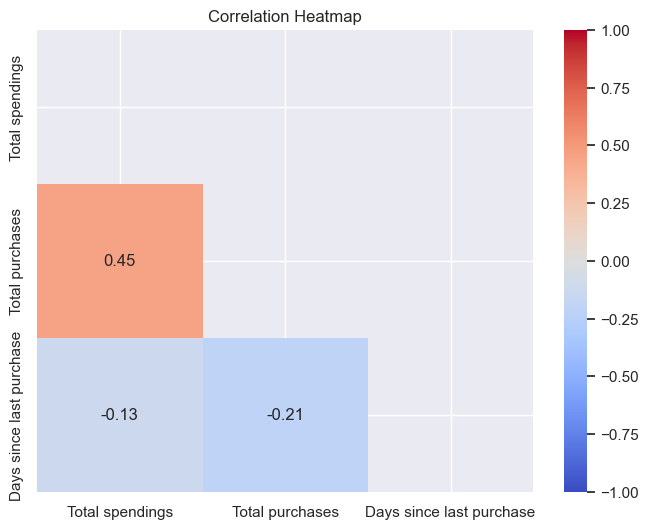

In [15]:
correlation_matrix = customer_df[
    ["Total spendings", "Total purchases", "Days since last purchase"]
].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

plt.title("Correlation Heatmap")

plt.show()

While the correlation between features appears weak and provides limited insights, there still seems to be a positive relation between *Total Spendings* and *Total Purchases*.

In [16]:
def remove_outliers(df: pd.DataFrame, column_names: list) -> pd.DataFrame:
    """Remove outliers from a DataFrame column using the IQR method.

    Args:
        df (pd.DataFrame): dataframe to be reduced
        column_name (List): column names containing the outliers

    Returns:
        pd.DataFrame: DataFrame with outliers removed
    """

    df_no_outliers = df.copy()

    for column_name in column_names:
        assert (
            column_name in df.columns
        ), f"Column '{column_name}' does not exist in the DataFrame."

        assert pd.api.types.is_numeric_dtype(
            df[column_name]
        ), f"Column '{column_name}' must be numerical"

        Q1 = df[column_name].quantile(0.25)
        Q3 = df[column_name].quantile(0.75)

        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_no_outliers = df_no_outliers[
            (df_no_outliers[column_name] >= lower_bound)
            & (df_no_outliers[column_name] <= upper_bound)
        ]

    return df_no_outliers

In [17]:
def distribution_graphs(
    df: pd.DataFrame, columns: list, graph_type: str = "hist"
) -> plt.figure:
    """
    Plot distribution graphs for specified columns in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - columns (list): A list of column names to plot.
    - graph_type (str, optional): The type of graph to plot. Default is "hist".
        Options: "hist" for histograms, "box" for boxplots.

    Returns:
    - plt.figure: Matplotlib figure object.

    Raises:
    - ValueError: If an invalid value is provided for graph_type.
    """
    num_cols = len(columns)
    num_rows = (num_cols + 2) // 3

    _, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if graph_type == "hist":
            sns.histplot(
                data=df,
                x=column,
                ax=axes[i],
            )
        elif graph_type == "box":
            sns.boxplot(
                y=df[column],
                ax=axes[i],
            )
            axes[i].set_xlabel(column)
            axes[i].set_ylabel("")
        else:
            raise ValueError("Invalid value for graph_type. Use 'hist' or 'box'.")

    plt.tight_layout()
    plt.show()

#### 3.2. Data distribution

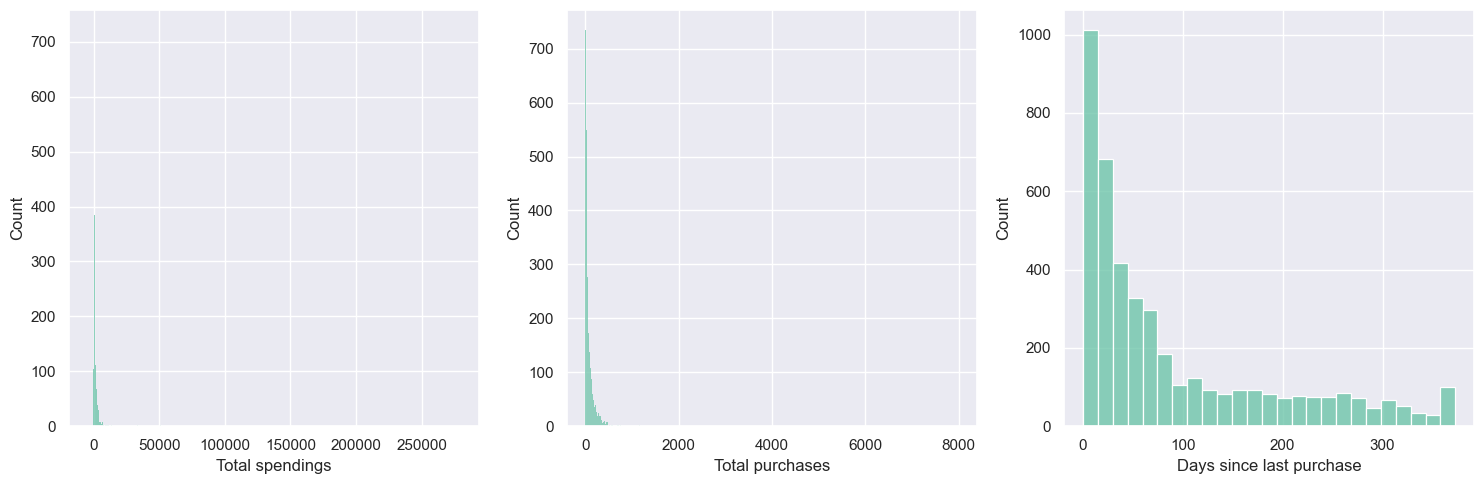

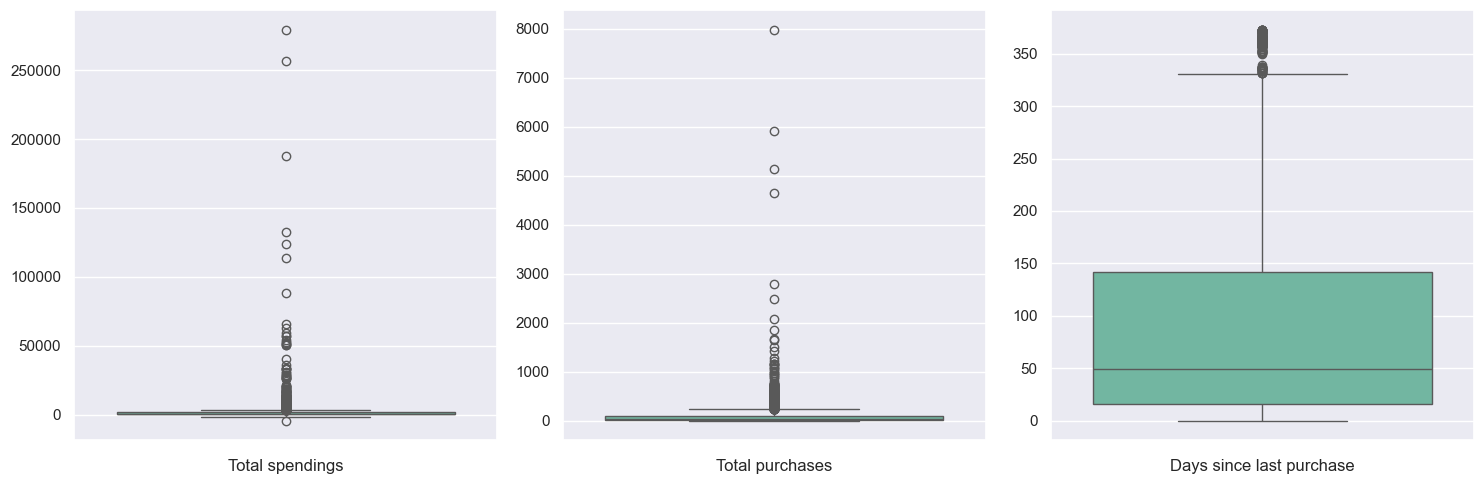

In [18]:
distribution_graphs(
    customer_df,
    ["Total spendings", "Total purchases", "Days since last purchase"],
    graph_type="hist",
)

distribution_graphs(
    customer_df,
    ["Total spendings", "Total purchases", "Days since last purchase"],
    graph_type="box",
)

- Data is positevly skewed
- There seem to be way too many outliers that could be removed from the data, IQR method can be used

#### 3.3. Removing outliers

- The IQR (Interquartile Range) method for removing outliers involves calculating the IQR, which is the range between the first quartile (25th percentile) and the third quartile (75th percentile).
- Then, any data points outside a certain range, typically defined as 1.5 times the IQR below the first quartile or above the third quartile, are considered outliers and can be removed.

In [19]:
customer_df_wo_outliers = remove_outliers(
    customer_df, ["Total spendings", "Total purchases", "Days since last purchase"]
)

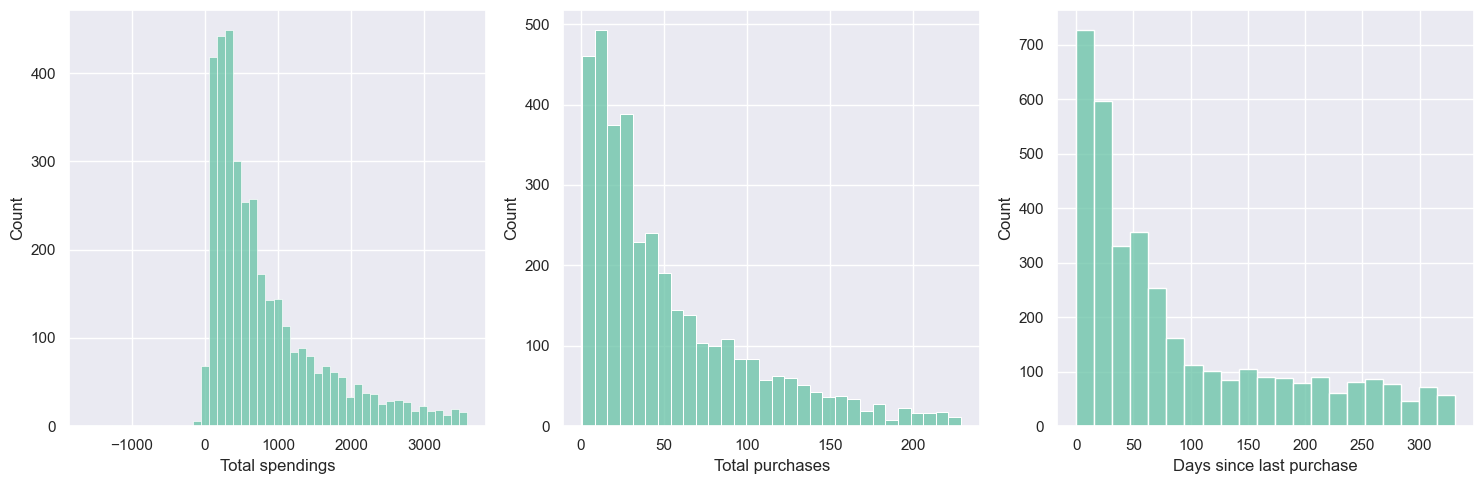

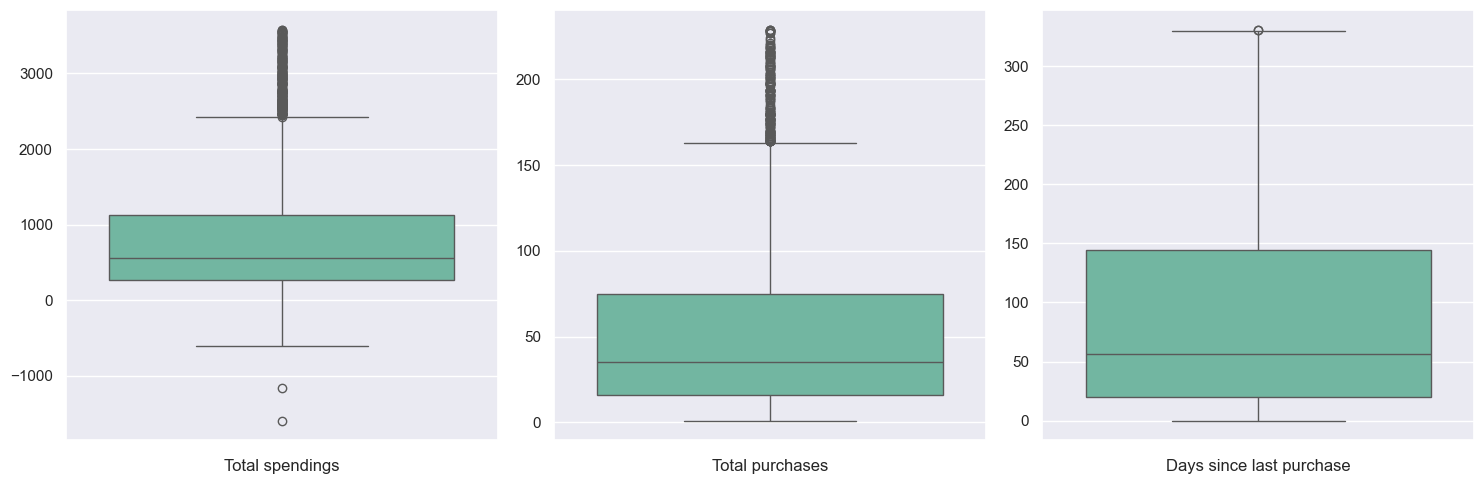

In [20]:
distribution_graphs(
    customer_df_wo_outliers,
    ["Total spendings", "Total purchases", "Days since last purchase"],
    graph_type="hist",
)

distribution_graphs(
    customer_df_wo_outliers,
    ["Total spendings", "Total purchases", "Days since last purchase"],
    graph_type="box",
)

#### 4. Clustering customers

In [21]:
def calculate_wcss(data: pd.DataFrame, max_clusters: int = 10) -> list[int]:
    """
    Calculate the Within-Cluster Sum of Squares (WCSS) for different numbers of clusters.

    Args:
        data (pd.DataFrame): The DataFrame to be clustered.
        max_clusters (int, optional): The maximum number of clusters to try. Defaults to 10.

    Returns:
        list[int]: A list of integers representing the Within-Cluster Sum of Squares (WCSS)
                   for each number of clusters.

    The function uses the KMeans clustering algorithm to fit the data for different
    numbers of clusters and calculates the WCSS, which measures the compactness of the clusters.
    The WCSS is stored in a list for each iteration, allowing for analysis of the elbow method
    to determine the optimal number of clusters.
    """
    wcss = []

    for i in range(1, max_clusters + 1):
        kmeans = KMeans(
            n_clusters=i,
            random_state=123,
            n_init="auto",
        )

        kmeans.fit(data)

        wcss.append(kmeans.inertia_)

    return wcss

#### 4.1. Scaling data and using *Elbow method* to find optimal count of clusters

- *Scaling data*
    - Scaling the data is essential to ensure that features with different scales do not dominate the clustering process.
    - Data scaling involves transforming the values of each feature so that they have a *mean of 0* and a *standard deviation of 1*.
    - Prevents any particular feature from disproportionately influencing the clustering algorithm.

- *Plot the Elbow Curve* 
    - Create a plot with the number of clusters (k) on the x-axis and the corresponding WCSS on the y-axis. 
    - The plot typically resembles an arm, and the "elbow" of the curve is the point where the reduction in WCSS starts to slow down, forming an angle.
- *Identify the Elbow*
    - The optimal number of clusters is often located at the "elbow" of the curve. 
    - This is the point where adding more clusters provides diminishing returns in terms of explaining the variance in the data.

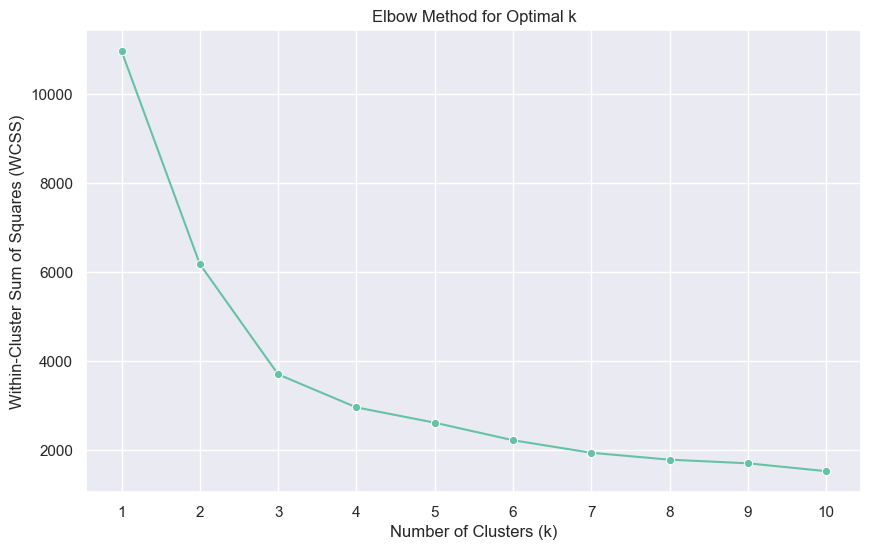

In [22]:
features = ["Total spendings", "Total purchases", "Days since last purchase"]
X_dummy = customer_df_wo_outliers[features]

scaler = StandardScaler()

customer_df_scaled = scaler.fit_transform(X_dummy)
customer_df_scaled = pd.DataFrame(customer_df_scaled, columns=features)

wcss_values = calculate_wcss(customer_df_scaled)

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(wcss_values) + 1), y=wcss_values, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.xticks(range(1, len(wcss_values) + 1))
plt.show()

Looks like the best option seems to be *3 clusters*

In [23]:
num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters, random_state=123, n_init="auto")
customer_df_wo_outliers["Cluster"] = kmeans.fit_predict(customer_df_scaled)

#### 4.2 Displaying relationship between each cluster

<Figure size 1800x2000 with 0 Axes>

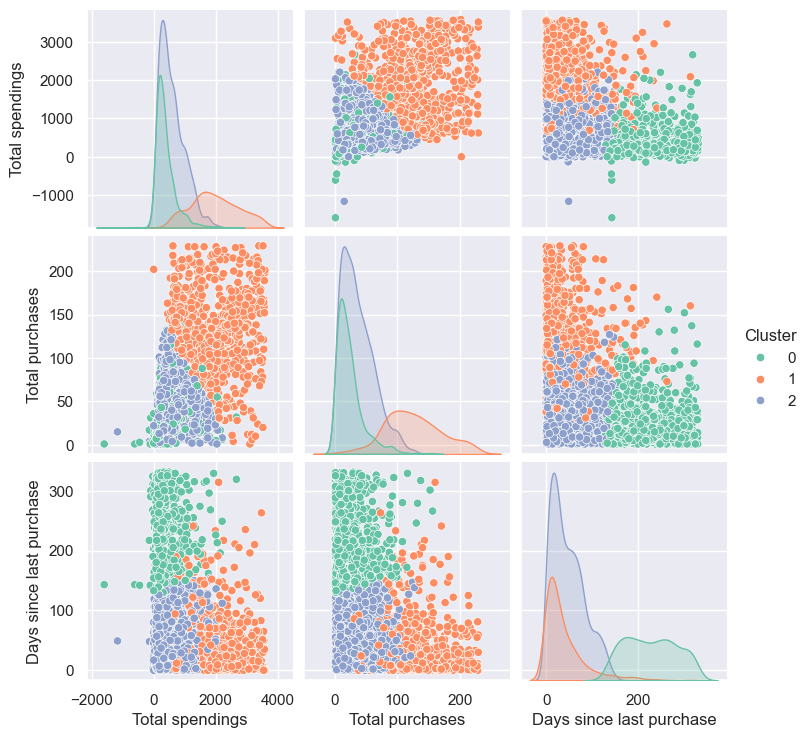

In [24]:
plt.figure(figsize=(18, 20))
sns.pairplot(
    customer_df_wo_outliers,
    hue="Cluster",
    vars=["Total spendings", "Total purchases", "Days since last purchase"],
    palette="Set2",
)

plt.show()

In [25]:
fig = px.scatter_3d(
    customer_df_wo_outliers,
    x="Days since last purchase",
    y="Total purchases",
    z="Total spendings",
    color="Cluster",
    size_max=50,
    opacity=0.7,
    title="Interactive 3D Scatter Plot of Customer Segmentation",
    labels={
        "Total purchases": "Total purchases",
        "Total spendings": "Total spendings",
        "Days since last purchase": "Days since last purchase",
    },
    color_continuous_scale="viridis",
    height=800,
    width=800,
)

fig.update_layout(scene=dict(zaxis=dict(nticks=4, tickfont=dict(size=10))))

fig.update_traces(marker=dict(line=dict(color="rgba(0, 0, 0, 0.15)", width=2)))

fig.show()

![Static Plot](plots/static_plot.png)

In [26]:
cluster_avg = (
    customer_df_wo_outliers.groupby("Cluster")
    .agg(
        {
            "Total spendings": "mean",
            "Days since last purchase": "mean",
            "Total purchases": "mean",
        }
    )
    .sort_values("Total spendings", ascending=False)
    .map("{:.2f}".format)
)

cluster_avg.columns = [f"{col} (Mean)" for col in cluster_avg.columns]
cluster_avg

,Total spendings (Mean),Days since last purchase (Mean),Total purchases (Mean)
Cluster,,,
1,1958.25,38.27,125.05
2,583.64,47.05,36.40
0,373.72,228.11,23.84


### 5. Conclusion

- *Cluster 0*:
  - Makes the fewest purchases.
  - Spends the least.
  - Doesn't have many recent orders.

- *Cluster 1*:
  - Conducts the highest number of purchases.
  - Has the most recent orders.
  - Spends the most.

- *Cluster 2*:
  - Falls somewhere in between *Cluster 0* and *Cluster 1*.
  - Closer to *Cluster 0*
